# SIM City Example

This notebook serves to as quick tutorial to run the simulation. This consists of: 

1) defining the agent, 
2) define the parameters for the rules of the game, 
3) interface with the environment and finally,
4) collect and visualise the data. 

Some of the  code and most of the documentation are generated by AI.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
#let's import our pre-requisites packages
import json
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

from environments.environment import CityModel
from update_rules.update_rules import DefaultUpdateRules, DefaultUpdateRulesParameters
from agents.agent import CityPlanner
import visualisation
from utils import TileTypes


## Defining the Agent

First we define our agent. In this case, let's just create a simple agent that randomly place tiles. It might be confusing to see `model` and `update_rules` here but bear with me. 

Note the `destroy_tile_penalty`. This incurs when a destroy action is invoked, it creates pollution.

In [3]:
class SillyCityPlanner(CityPlanner):
    
    RAND_TILES = [e.value for e in TileTypes if e!=TileTypes.BARREN]

    def __init__(self, model, destroy_tile_penalty=10):
        super().__init__(model, destroy_tile_penalty)

        all_steps = []
        for row in range(model.width):
            for col in range(model.height):
                all_steps.append((row, col))
        self.all_steps = np.array(all_steps)
        self.model.rng.shuffle(self.all_steps)

    def decide(self):
        #get the width and height from the model
        time_step = self.model.time_step

        rand_tile = self.model.rng.choice(self.RAND_TILES)
        x_row, y_col = self.all_steps[time_step]
        self.place(x_row, y_col, rand_tile)

    def update(self, **kwargs):
        # default rules will save the current population pollution 
        # gained for the current time step, so we shall get it from them
        self.total_population += self.model.update_rules.curr_pop_g
        self.total_pollution += self.model.update_rules.curr_poll_g
        self.population_cap = self.model.update_rules.population_cap

    def warm_start(self, **kwargs):
        # In case you want to re-initialise agent with some existing
        # policies or states from previous episodes
        raise NotImplementedError("This class don't need any warm starts")

    def print_stats(self):
        print(f"{'='*5}Stats{'='*5}")
        print(f"Population: {self.total_population} / {self.population_cap}")
        print(f"Pollution: {self.total_pollution}")

## Define the Parameters for the Rules

ext, we define the parameters of our rules i.e, how much pollution/population gained for each tile, etc. The rules define how pollution and population are calculated, the parameters defined how much they are gained.


As the project developed, new updates and subsequently parameters will be created so they are abstracted out from the environment. Also, the parameters should be abstracted out as well, so others can tweak the values around if they wish to leave the rules alone.

In [4]:
with open("data/update_parameters/DefaultUpdateRule.json") as f:
    default_rule_parameters = json.load(f)
    
default_rule_parameters = DefaultUpdateRulesParameters(**default_rule_parameters)

# define the class with empty parameters and set the parameters thereafter. 
# In case for extensions, one can override the parameters
update_rules = DefaultUpdateRules()
update_rules.set_parameters(default_rule_parameters)


## Interfacing with the Environment

In [5]:
#let's first define some constants we will be using
width = 16
height = 16

#increase this trial if you wish to get the full trajectory
episodes =1
# allow the agent to fully place all tiles
duration = width*height


Finally, we define our environment. Note, Mesa uses width as row, height as column for a 2D numpy array so I shall follow their convention not matter how disagreeable I find it >:( This also applies to x, y peppered around the code: x = row, y = column. That's why you will see `x_row` and `y_col` thrown alot.

`collect_rate` refers to how often we save the state of the environment. This can be quite memory intensive so consider increasing it when width and height increases.

You will notice how the model, update rules and agent are so entwined with one another. I can't find a good solution for this, also Mesa framework kinda encourage this between model and agent.

Anyway, let's start the simulation.

In [6]:
models = []
for episode in range(episodes):
    #for each trial, we re-define the environment and reset the rules
    update_rules = DefaultUpdateRules()
    update_rules.set_parameters(default_rule_parameters)
    #agents are created via some internal mechanism within Mesa mode class
    model = CityModel(SillyCityPlanner, width, height, update_rules, collect_rate=1.0)
    
    for timestep in range(duration):
        model.step()

    #post processing here, save agent's policies, etc.
    #we will just save the model for now for visualisation
    models.append(model)

## Collect and Visualise Data

Each model saves the following for time step $t$ (based on `collect_rate`)

| Reporter Type | Variable Name | Description | Data Source | Remarks |
|--------------|---------------|-------------|-------------| ---------|
| **Model** | City | Complete city layout/tile configuration | `model.grid.tile._mesa_data` | The 2D numpy array of the city grid |
| **Model** | Population Gain | Current population gain value | `model.update_rules.curr_pop_g` | Total population gained, taking into account population post modifiers |
| **Model** | Pollution Gain | Current pollution gain value | `model.update_rules.curr_poll_g` |  Total pollution gained, taking into account any pollution post modifiers |
| **Model** | Population Gain Grid | Spatial grid of population gains | `model.grid.pop_g._mesa_data` | Population gained for each cell. Represented as 2D array. |
| **Model** | Pollution Gain Grid | Spatial grid of pollution gains | `model.grid.poll_g._mesa_data` | Pollution gained for each cell. Represented as 2D array. |
| **Model** | Total Residence | Count of residential tiles | `np.count_nonzero(model.residence_tiles)` | Number of residence tiles |
| **Model** | Total Industries | Count of industrial tiles | `np.count_nonzero(model.industry_tiles)` | Number of industry tiles  |
| **Model** | Total Greenery | Count of greenery tiles | `np.count_nonzero(model.greenery_tiles)` | Number of greenery tiles |
| **Model** | Total Service | Count of service tiles | `np.count_nonzero(model.service_tiles)` | Number of service tiles |
| **Model** | Total Road | Count of road tiles | `np.count_nonzero(model.road_tiles)` | Number of road tiles |
| **Agent** | Total Population | Population per agent | `agent.total_population` | total population for so far |
| **Agent** | Total Pollution | Pollution per agent | `agent.total_pollution` | total pollution for so far |
| **Agent** | Population Cap | Population capacity per agent | `agent.population_cap` | population cap so far |


Let's see what kind of dysfunctional city our random agent creates. I have left some helper function in `visualisation.py` to visualise  the data above

In [7]:
# let's just see what kind of data are captured
collected_model_data = model.data_collectors.get_model_vars_dataframe()
collected_model_data

,City,Population Gain,Pollution Gain,Population Gain Grid,Pollution Gain Grid,Total Residence,Total Industries,Total Greenery,Total Service,Total Road
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.500000,1.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,0,0,0,1
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1.425000,2.5,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1,0,0,0,1
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4.441250,7.5,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1,0,0,1,1
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2.725313,7.5,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1,0,1,1,1
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1.408078,91.5,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...
251,"[[1, 2, 2, 5, 2, 3, 3, 3, 5, 1, 5, 2, 5, 5, 2,...",0.000000,1534.0,"[[1.2, 2.0, 2.0, 0.5, 2.0, 8.0, 8.0, 8.0, 0.5,...","[[0.0, 0.0, 0.0, 6.0, 5.0, 5.0, 5.0, 5.0, 6.0,...",50,48,49,50,55
252,"[[1, 2, 2, 5, 2, 3, 3, 3, 5, 1, 5, 2, 5, 5, 2,...",0.000000,1534.0,"[[1.2, 2.0, 2.0, 0.5, 2.0, 8.0, 8.0, 8.0, 0.5,...","[[0.0, 0.0, 0.0, 6.0, 5.0, 5.0, 5.0, 5.0, 6.0,...",50,49,49,50,55
253,"[[1, 2, 2, 5, 2, 3, 3, 3, 5, 1, 5, 2, 5, 5, 2,...",9.611206,1535.5,"[[1.2, 2.0, 2.0, 0.5, 2.0, 8.0, 8.0, 8.0, 0.5,...","[[0.0, 0.0, 0.0, 6.0, 5.0, 5.0, 5.0, 5.0, 6.0,...",51,49,49,50,55
254,"[[1, 2, 2, 5, 2, 3, 3, 3, 5, 1, 5, 2, 5, 5, 2,...",0.000000,1535.5,"[[1.2, 2.0, 2.0, 0.5, 2.0, 8.0, 8.0, 8.0, 0.5,...","[[0.0, 0.0, 0.0, 6.0, 5.0, 5.0, 5.0, 5.0, 6.0,...",51,50,49,50,55


In [8]:
collected_agent_data = model.data_collectors.get_agent_vars_dataframe()
collected_agent_data

,,Total Population,Total Pollution,Population Cap
Step,AgentID,,,
1,1,0.500000,1.0,0
2,1,1.925000,3.5,10
3,1,6.366250,11.0,10
4,1,9.091563,18.5,10
5,1,10.499641,110.0,10
...,...,...,...,...
252,1,503.703641,256087.0,500
253,1,503.703641,257621.0,500
254,1,513.314848,259156.5,510


In [9]:
#let's just define how 
def display_grid(animator):
    """Display the widget interface."""
    controls = widgets.HBox([animator.play_button, animator.slider, animator.speed_slider])
    display(widgets.VBox([controls, animator.output]))

# we will need to define which grid are discrete and which grid are continuous
grid_is_discrete = {
    "City": True,
    "Population Gain Grid": False,
    "Pollution Gain Grid": False
}

#what grid we wish to visualise
grid_cols = ['City', 'Population Gain Grid', 'Pollution Gain Grid']
data = collected_model_data[grid_cols]

print("Don't use the play button, it's not working for now. The slider is though.")

animator = visualisation.GridAnimator(data, grid_is_discrete, fps=1)
display_grid(animator)

Don't use the play button, it's not working for now. The slider is though.


Now let's visualise other data over time. As we can see population gain fluctuate over time, possibly because it keep hitting the population cap (when each residence only provdes 10 cap). You will probably see something different here if you tweak the rule parameters

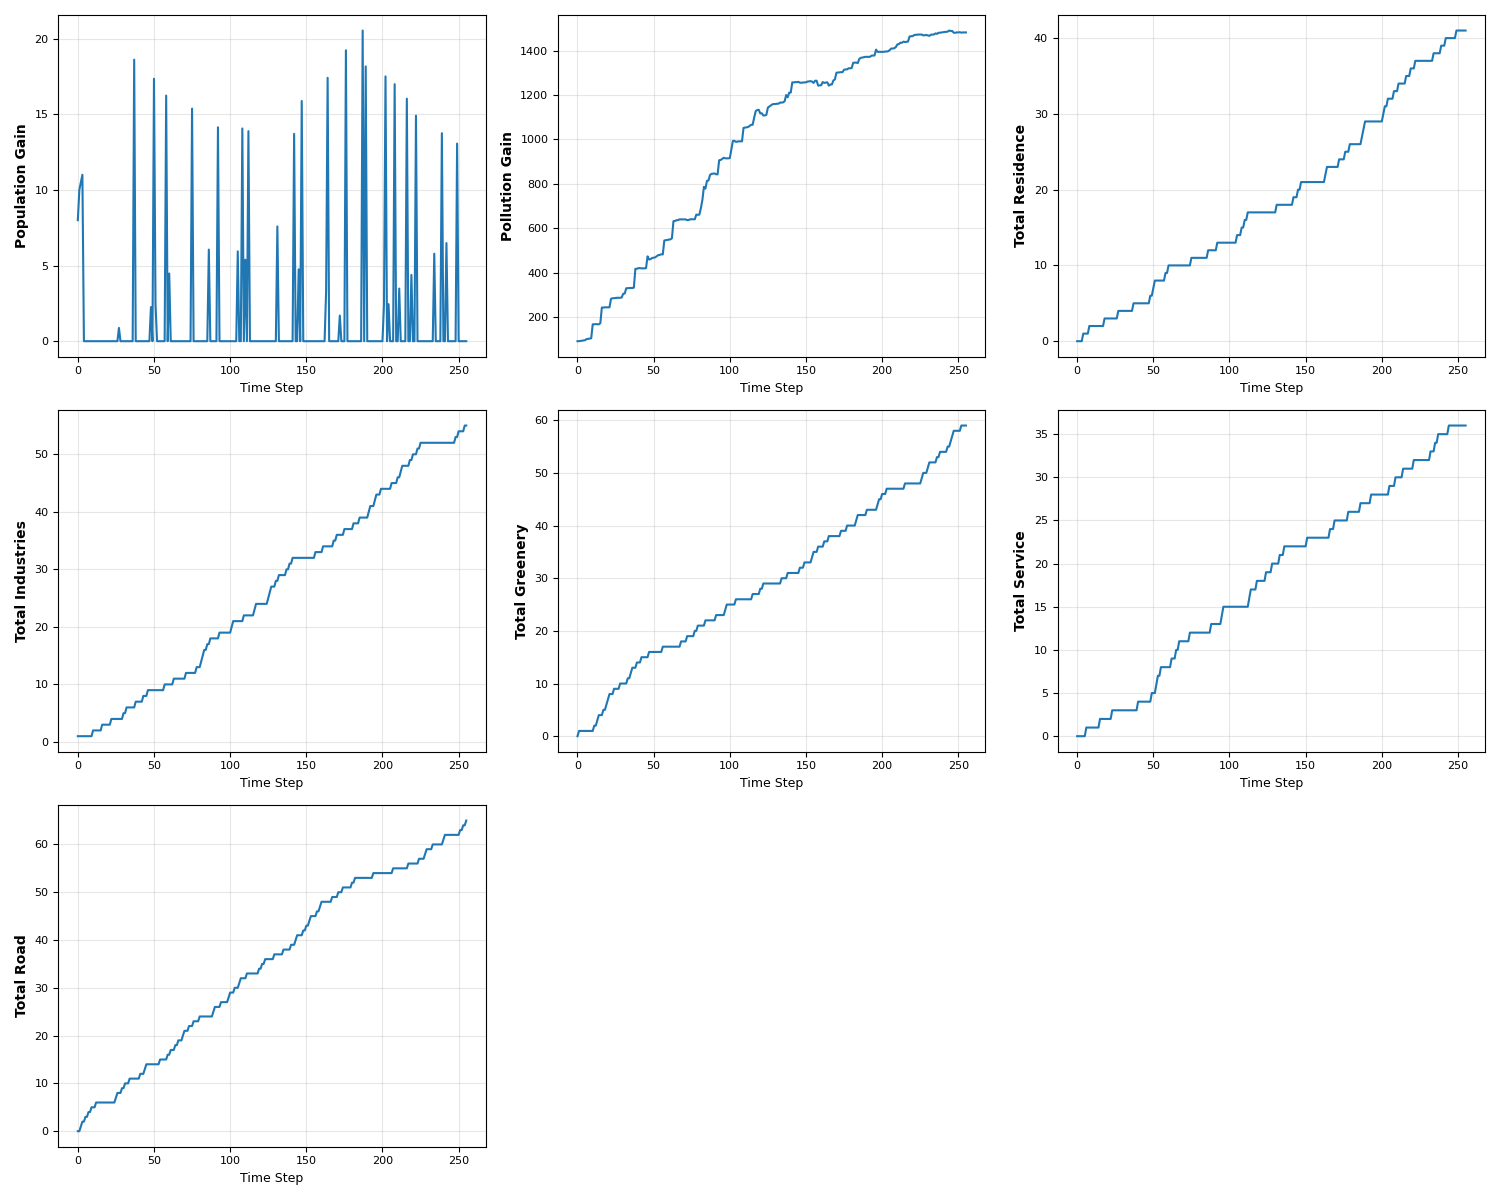

In [10]:
#this method will only set the axis for you, you will still need to call plt.show()
visualisation.plot_selected_columns(collected_model_data, ["Population Gain", "Pollution Gain", "Total Residence", 
                                                           "Total Industries", "Total Greenery", "Total Service", "Total Road"])
plt.tight_layout()
plt.show()


Now let's see the agent's internal scoring. As we can see population grow kinda hits the population cap really fast (population cap per residence = 10), so we might need to increase. Again, if you have changed the parameters, it might be different.

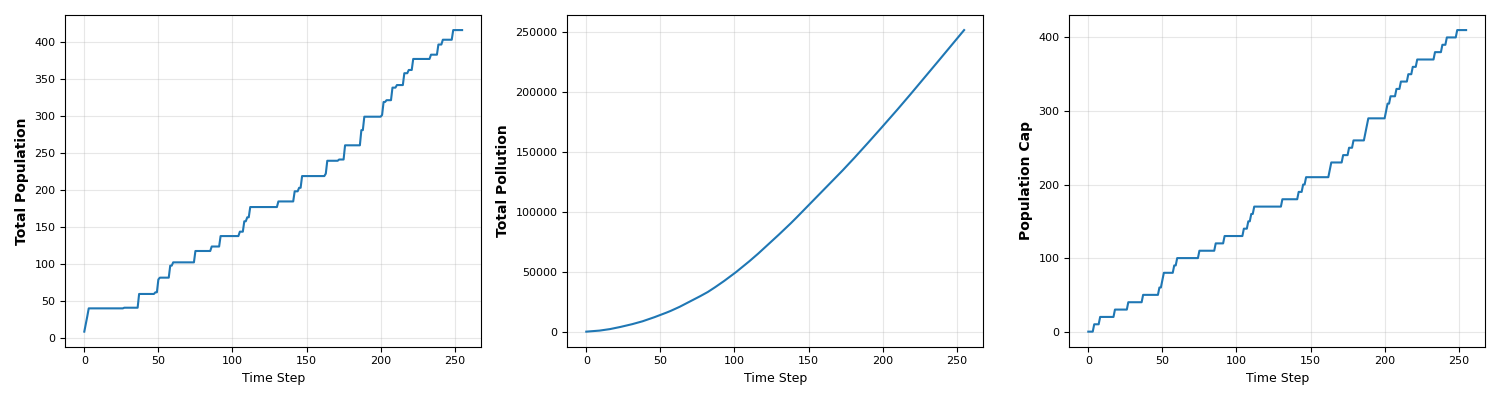

In [11]:
# Now the agent 
visualisation.plot_selected_columns(collected_agent_data, ["Total Population", "Total Pollution", "Population Cap"])
plt.tight_layout()
plt.show()